In [174]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay

In [175]:
# ift6758/data/milestone2/q3_baseline.py
import sys
sys.path.append('../ift6758/data/milestone2')
from q3_baseline import read_dataset,\
                        plot_models 

In [176]:
# Read CSV files
dataset = pd.read_csv('/Users/sunjiaao/Courses/IFT6758/m2_CSV_data/all_data.csv')

In [177]:
dataset.head()

,eventIdx,game_id,Distance from Net,Angle from Net,Is Goal,Is Net Empty
0,5,2015020364,43.829214,117.149682,0,0
1,12,2015020364,13.416408,116.565051,0,0
2,13,2015020364,12.369317,14.036243,0,0
3,18,2015020364,9.899495,135.000000,0,0
4,32,2015020364,42.201896,76.293039,0,0


In [178]:
# Separate features and labels 
X = dataset[['eventIdx', 'game_id', 'Distance from Net',
             'Angle from Net', 'Is Net Empty']]
y = dataset[['Is Goal']]

# Question 3.1

In [202]:
# ==========================================================================================
# Question 1: 
# ==========================================================================================
def q3_1(X, y):
    '''
    Using only the 'distance' feature, train a Logistic Regression classifier 
    with the completely default settings.    
    '''
    # Create a training and validation split
    #['Distance from Net', 'Angle from Net']
    
    X_train, X_test, y_train, y_test = train_test_split(X[['Distance from Net']],y,test_size=0.20,random_state=50)

    # Logistic regression model fitting
    clf = LogisticRegression()
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)

    # Predict on validation set
    y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f'Accuracy score is {accuracy}')
    # Accuracy score is 0.9039567998457138
    
    print(y.count())
    print((y == True).sum())
    print((y == False).sum())
    print((y == True).sum() / y.count())
    print((y == False).sum() / y.count())
    print(y_test.shape)
    print(np.count_nonzero(y_pred == 0))
    
q3_1(X, y)

Accuracy score is 0.9039567998457138
Is Goal    311106
dtype: int64
Is Goal    29187
dtype: int64
Is Goal    281919
dtype: int64
Is Goal    0.093817
dtype: float64
Is Goal    0.906183
dtype: float64
(62222, 1)
62222


# Question 3.2

In [185]:
# ==========================================================================================
# Question 3.2:
# ==========================================================================================
def q3_2(X, y, features=['Distance from Net']):
    '''
     Calculate the probability.
     In X_test_pred_proba, the first column is label 0, the second one is label 1.  
    '''
    # Create a training and validation split
    X_train, X_test, y_train, y_test = train_test_split(X[features],y,test_size=0.20,random_state=50)

    # Logistic regression model fitting
    clf = LogisticRegression()
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)
    
    # use clf.classes_ to check the order of labels     

    # Predict the probability
    X_test_pred_proba = clf.predict_proba(X_test)

    # print(f'The probabilities on validation set is\n {X_test_pred_proba}')
    
    return X_test_pred_proba#, y_test

q3_2(X, y)

array([[0.92323014, 0.07676986],
       [0.88364339, 0.11635661],
       [0.88192328, 0.11807672],
       ...,
       [0.90970915, 0.09029085],
       [0.85868169, 0.14131831],
       [0.8929553 , 0.1070447 ]])

In [186]:
q3_2(X,y,features=['Angle from Net'])

array([[0.90724237, 0.09275763],
       [0.90747101, 0.09252899],
       [0.90601478, 0.09398522],
       ...,
       [0.90785768, 0.09214232],
       [0.90611084, 0.09388916],
       [0.90793462, 0.09206538]])

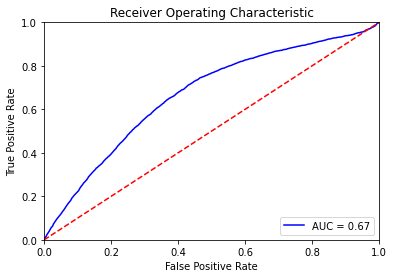

In [187]:
def q3_2_roc(X, y, probs):
#     https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
    # Create a training and validation split
    X_train, X_test, y_train, y_test = train_test_split(X[['Distance from Net']],y,test_size=0.20,random_state=50)
    is_goal = probs[:,1]

    fpr, tpr, threshold = metrics.roc_curve(y_test, is_goal)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
probs = q3_2(X, y)
q3_2_roc(X, y, probs)

In [188]:
def get_percentile(X, y, probs, features=['Distance from Net']):
    '''
    Return a df that has four columns:
        * 'index': index in y_test.
        * 'Goal prob': Goal probability.
        * 'Is Goal': 0 means not goal; 1 means goal.
        * 'Percentile': Calculated percentile, range from 0.00 to 99.99.
    The df is sorted by 'Percentile'.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X[features],y,test_size=0.20,random_state=50)

    # Create a df for shot probabilities
    probs_df = pd.DataFrame(probs)
    probs_df = probs_df.rename(columns={0: "Not Goal prob", 1: "Goal prob"})

    # Concatenate 'Goal Probability' and 'Is Goal' into one df. Each column has values: 0 and 1. 
    df = pd.concat([probs_df["Goal prob"].reset_index(drop=True),\
                    y_test["Is Goal"].reset_index(drop=True)],axis=1)

    # Add 'Percentile' column
    percentile_series=df['Goal prob'].rank().apply(lambda x: 100.0*(x-1)/df.shape[0])
    df['Percentile'] = percentile_series

    # Sort the df by the value of percentile. Min is 0.0000, max is 99.9967
    df = df.sort_values(by=['Percentile'])
    df = df.reset_index()
    
    return df

In [189]:
perc_df = get_percentile(X, y, probs)
perc_df.head(10)

,index,Goal prob,Is Goal,Percentile
0,36250,0.005271,0,0.000000
1,49783,0.005300,0,0.001607
2,2062,0.005390,0,0.003214
3,23325,0.005393,1,0.004821
4,59590,0.005502,1,0.006429
5,7908,0.005509,0,0.008839
6,17520,0.005509,0,0.008839
7,49587,0.005514,0,0.011250
8,29105,0.005519,1,0.012857
9,28713,0.005534,0,0.014464


In [190]:
angle_probs = q3_2(X,y,features=['Angle from Net'])
angle_perc_df = get_percentile(X, y, angle_probs, features=['Angle from Net'])
angle_perc_df.head(10)

,index,Goal prob,Is Goal,Percentile
0,20205,0.091059,0,0.03375
1,55967,0.091059,0,0.03375
2,57170,0.091059,0,0.03375
3,61582,0.091059,0,0.03375
4,5412,0.091059,0,0.03375
5,14097,0.091059,0,0.03375
6,1513,0.091059,0,0.03375
7,3702,0.091059,0,0.03375
8,7297,0.091059,1,0.03375
9,41031,0.091059,0,0.03375


In [191]:
angle_perc_df.tail()

,index,Goal prob,Is Goal,Percentile
62217,5635,0.096208,1,99.991964
62218,30060,0.096239,0,99.993571
62219,43659,0.096307,0,99.995982
62220,42405,0.096307,0,99.995982
62221,49844,0.096354,0,99.998393


In [192]:
def get_rate(df, function_type='goal_rate'):
    '''
    Divide the sorted df into 10 bins, each two adjacent bins have a difference of 10 on percentile.
    As we noticed, the percentile ranges from 0 to 99.99, we set bin range from 0 to 100, 
    so, there are 10 bins: [0:10], [10:20], ..., [90:100].
    Given function type, calculates the corresponding rate. 
    
    :params df: A sorted percentile df, calculated by get_percentile().
    :params function_type: Function type. Default value 'goal_rate'. 
                           Another option is 'cumulative_rate'.
    
    :return goal_rate_df: A df has shape (10, 2). First column is rate, second column is bin index. 
    '''
    
    # In goal_rate function, the list should have a length of 10, 
    # each item is the goal rate of that bin. 
    # For example, if there are 5000 records have percentiles between 0 and 10, 
    # and there are 250 goals, the goal rate is 250/5000=0.05.
    # So, rate_list[0] is 0.05
    rate_list = []
    
    # Find total number of goals
    total_goals = df['Is Goal'].value_counts()[1]
    
    cumulative_counts = 0

    i = 0
    i_list = []
    
    # 91 is the lower bound of last bin
    while i<92:
        i_list.append(i)

        # current bin size
        lower_bound = i
        upper_bound = (i+10)

        # find all records that have percentiles fall in this range
        rows = df[(df['Percentile']>=lower_bound) &
                  (df['Percentile']<upper_bound)]
        
        # count the number of goals
        goals = rows['Is Goal'].value_counts()[1]

        shots = rows.shape[0]

        if function_type == 'goal_rate':
            rate = goals/shots
            
        elif function_type == 'cumulative_rate':
            cumulative_counts += goals
            rate = (cumulative_counts)/total_goals

        rate_list.append(rate)

        i+=10

    rate_list = [i*100 for i in rate_list]    
    
    # Combine goal rate list and percentile list into one df
    rate_df = pd.DataFrame(list(zip(rate_list, i_list)),\
                                columns=['Rate', 'Percentile'])
    
    return rate_df

goal_rate_df = get_rate(perc_df)
goal_rate_df

,Rate,Percentile
0,6.072289,0
1,3.530733,10
2,3.545528,20
3,4.738510,30
4,6.247950,40
5,9.395973,50
6,12.275641,60
7,14.777849,70
8,15.883489,80
9,19.569754,90


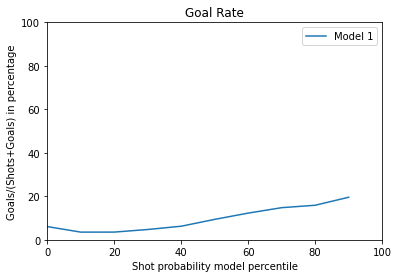

In [193]:
def plot_baseline_rates(df, x, y, function_type='goal_rate'):
    ax = plt.gca()
    plt.plot(
        df[x],
        df[y],
    )
    ax.set_ylim([0,100])
    ax.set_xlim([0,100])
    
    ax.legend(['Model 1'])
    
    plt.xlabel('Shot probability model percentile')
    
    if function_type == 'goal_rate':
        plt.title('Goal Rate')
        plt.ylabel('Goals/(Shots+Goals) in percentage')
    
    elif function_type == 'cumulative_rate':
        plt.title('Cumulative % of goals')
        plt.ylabel('Proportion')        
    
    plt.show()

plot_baseline_rates(goal_rate_df, 'Percentile', 'Rate')

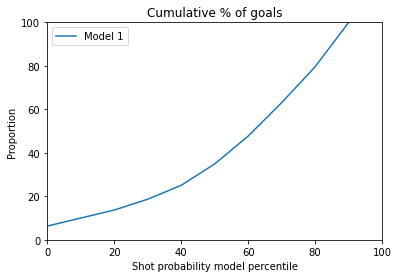

In [194]:
cumulative_rate = get_rate(perc_df, function_type='cumulative_rate') 
plot_baseline_rates(cumulative_rate, 'Percentile', 'Rate', function_type='cumulative_rate')

In [195]:
cumulative_rate

,Rate,Percentile
0,6.325301,0
1,10.006693,10
2,13.688086,20
3,18.691432,30
4,25.066934,40
5,34.906292,50
6,47.724230,60
7,63.085676,70
8,79.601740,80
9,100.000000,90


In [196]:
def plot_baseline_calibration(X, y, features=['Distance from Net']):
    
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    
    X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.20, random_state=50)
    
    clf = LogisticRegression()
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)
    
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=50,
        ax=ax_calibration_curve,
        label=f'{features}'
    )
    
    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plot")
    plt.ylabel('Fraction of positives')
    plt.xlabel('Mean predicted probability')
    plt.show()

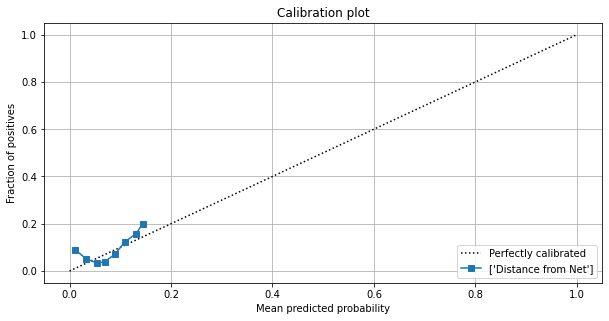

In [197]:
plot_baseline_calibration(X, y)

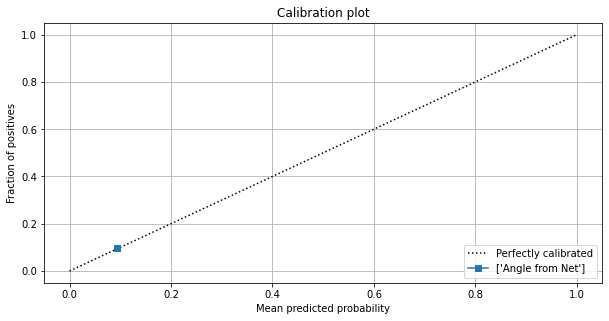

In [198]:
plot_baseline_calibration(X, y, features=['Angle from Net'])

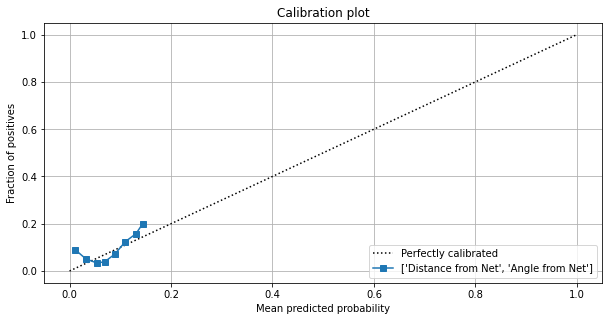

In [199]:
plot_baseline_calibration(X, y, features=['Distance from Net', 'Angle from Net'])

# Question 3.3

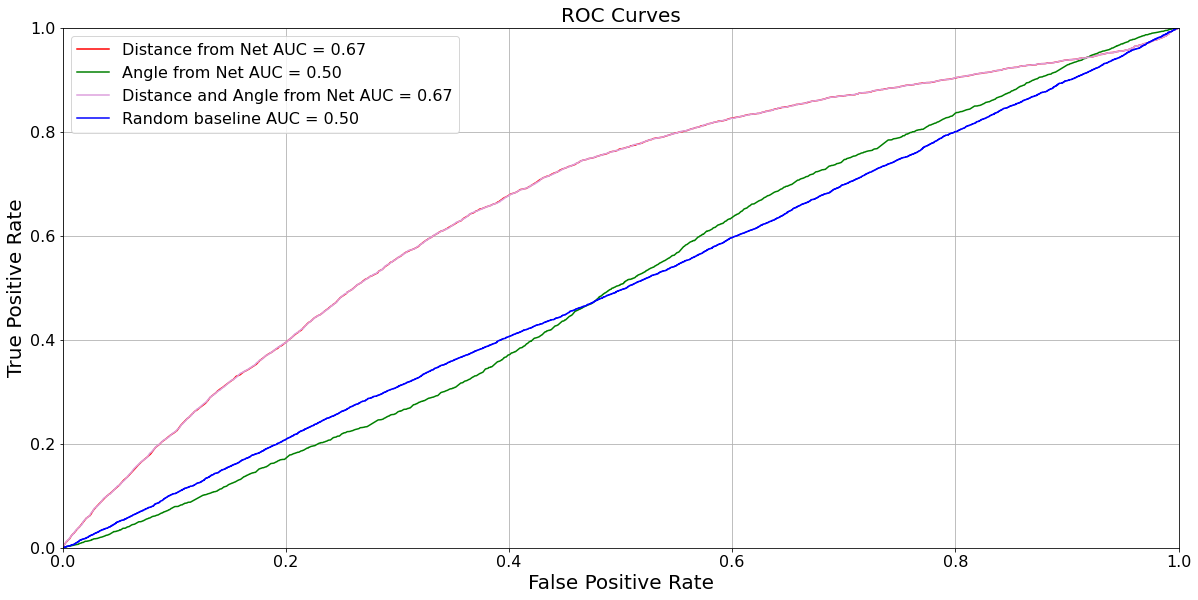

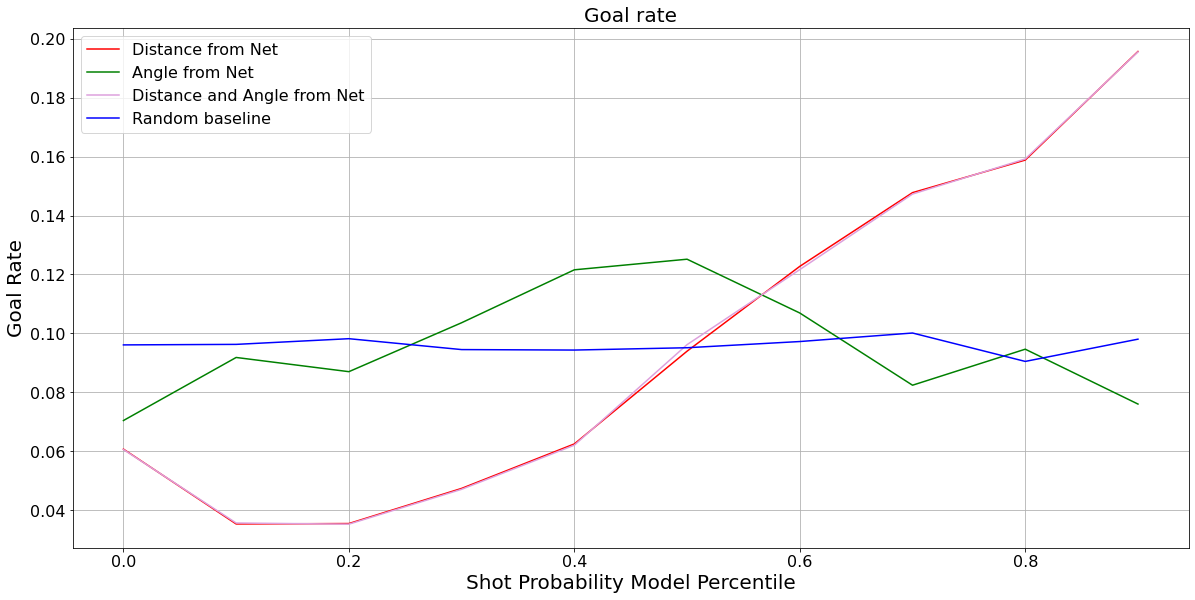

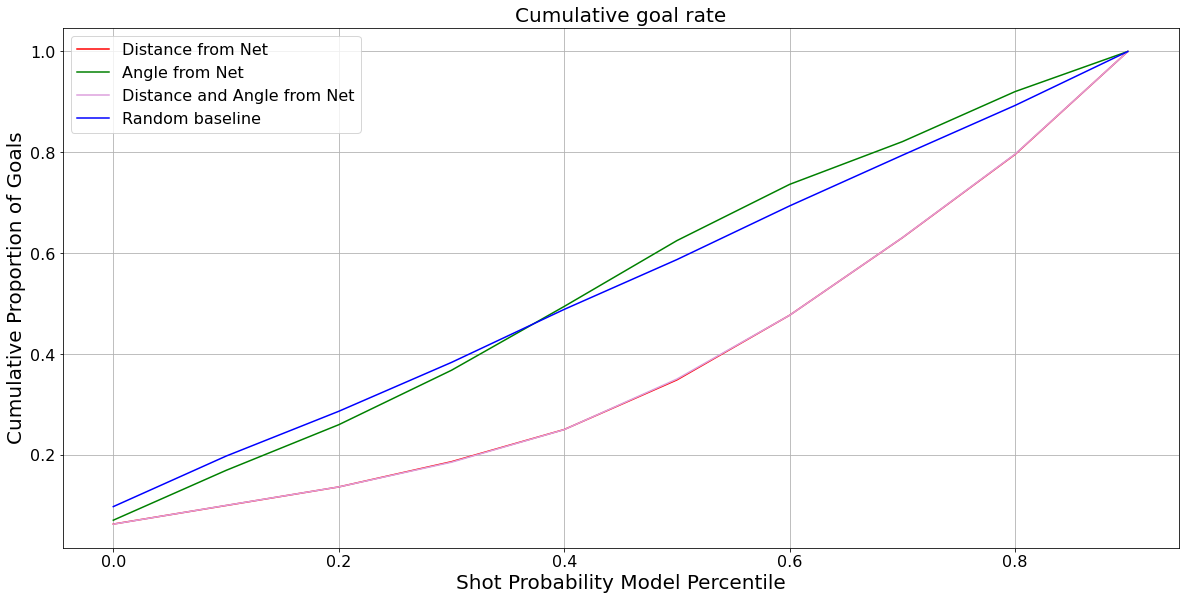

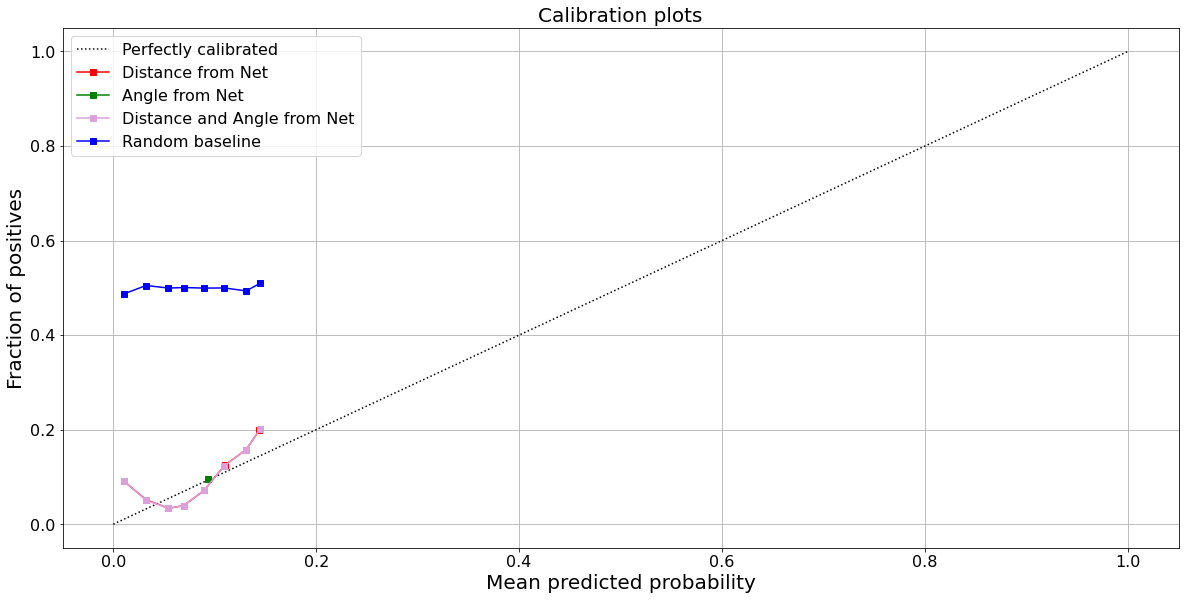

In [9]:
# Use q3_baseline.py

X,y = read_dataset()
plot_models(X, y, 'logreg')

In [156]:
from matplotlib.gridspec import GridSpec

feature_color_dict = {
    1: [['Distance from Net'], 'r'],
    2: [['Angle from Net'], 'g'],
    3: [['Distance from Net', 'Angle from Net'], 'plum'],
    4: ['Random baseline', 'b']
    }

In [157]:
def plot_roc(X, y, feature_color_dict):
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])    

    for k, v in feature_color_dict.items():
        
        features = v[0]
        color = v[1]
        
        if features != 'Random baseline':
            probs, y_test = q3_2(X, y, features)
            is_goal_probs = probs[:, 1]                
            curve_label = f'{features}'[2:-2] if len(features) == 1 else 'Distance and Angle from Net'

        # Random baseline
        else:
            is_goal_probs = np.random.uniform(0, 1, is_goal_probs.shape[0])
            curve_label = 'Random Baseline'

        fpr, tpr, threshold = metrics.roc_curve(y_test, is_goal_probs)
        
        roc_auc = metrics.auc(fpr, tpr)
        
        plt.plot(fpr, 
                 tpr, 
                 color=color, 
                 label=f'{curve_label} '+'AUC = %0.2f' % roc_auc)      
    
    plt.axis([0, 1, 0, 1])    
        
    plt.title('ROC Curves')
    plt.legend()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    
# plot_roc(feature_color_dict)

In [158]:
def plot_goal_rate(X, y, feature_color_dict):
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])    

    for k, v in feature_color_dict.items():
        
        features = v[0]
        color = v[1]
        
        if features != 'Random baseline':
            probs, y_test = q3_2(X, y, features)
            is_goal_probs = probs[:, 1]
            perc_df = get_percentile(X, y, probs, features)
            curve_label = f'{features}'[2:-2] if len(features) == 1 else 'Distance and Angle from Net'

        # Random baseline
        else:
            is_goal_probs = np.random.uniform(0, 1, is_goal_probs.shape[0])
            no_goal_prob = np.array([(1 - i) for i in is_goal_probs])
            probs = np.column_stack((is_goal_probs, no_goal_prob))
            perc_df = get_percentile(X, y, probs)
            curve_label = 'Random Baseline'

        goal_rate_df = get_rate(perc_df, function_type='goal_rate')
        plt.plot(
            goal_rate_df['Percentile']/100,
            goal_rate_df['Rate']/100,
            label=curve_label,
            color = color
        )   
       
    plt.title('Goal rate')
    plt.legend()
    plt.ylabel('Goal Rate')
    plt.xlabel('Shot Probability Model Percentile')
    plt.grid(True)
    
# plot_goal_rate(feature_color_dict)

In [159]:
def plot_cumulative_rate(X, y, feature_color_dict):
    
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    
    for k, v in feature_color_dict.items():
        
        features = v[0]
        color = v[1]

        if features != 'Random baseline':
            probs, y_test = q3_2(X, y, features)
            is_goal_probs = probs[:,1]   
            perc_df = get_percentile(X, y, probs, features)
            curve_label = f'{features}'[2:-2] if len(features) == 1 else 'Distance and Angle from Net'

        # Random baseline
        else:
            is_goal_probs = np.random.uniform(0,1,is_goal_probs.shape[0])
            no_goal_prob = np.array([(1-i) for i in is_goal_probs])
            probs = np.column_stack((is_goal_probs, no_goal_prob))
            perc_df = get_percentile(X, y, probs)
            curve_label = 'Random Baseline'
            
        cumulative_rate = get_rate(perc_df, function_type='cumulative_rate') 
        
        plt.plot(
            cumulative_rate['Percentile']/100,
            cumulative_rate['Rate']/100,
            label = curve_label,
            color = color,
        )  
   
    # plt.title('Cumulative goal rate')
    plt.title('Cumulative Proportion of Goals')
    plt.legend()
    plt.ylabel('Cumulative Proportion of Goals')
    plt.xlabel('Shot Probability Model Percentile')
    plt.grid(True)
    
# plot_cumulative_rate(feature_color_dict)

In [160]:
def plot_calibration(X, y, feature_color_dict):
    '''
    https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    '''

    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])

    for k, v in feature_color_dict.items():
        
        features = v[0]
        color = v[1]
        
        if features != 'Random baseline':
            X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.20, random_state=50)
            clf = LogisticRegression()
            y_train = y_train.values.ravel()
            clf.fit(X_train, y_train)
            curve_label = f'{features}'[2:-2] if len(features) == 1 else 'Distance and Angle from Net'
        
        # Random baseline
        else:
            goal_prob = np.random.uniform(0, 1, X_test.shape[0])
            
            # Value is 1 if goal_prob is greater than 0.5, 0 otherwise.
            y_test = np.zeros((goal_prob.shape[0],1))
            y_test[:,][np.where(goal_prob>0.5)]=1
            curve_label = 'Random Baseline'

        display = CalibrationDisplay.from_estimator(
                clf,
                X_test,
                y_test,
                n_bins=50,
                ax=ax_calibration_curve,
                color=color,
                label=curve_label
            )
    
    ax_calibration_curve.grid()
    ax_calibration_curve.set_title("Calibration plots")
    plt.ylabel('Fraction of positives')
    plt.xlabel('Mean predicted probability')
    plt.show()
    
     
# plot_calibration(feature_color_dict)

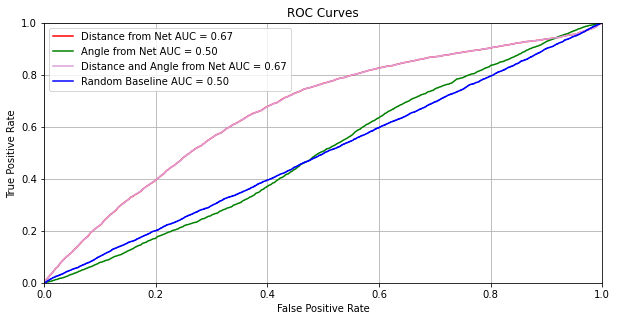

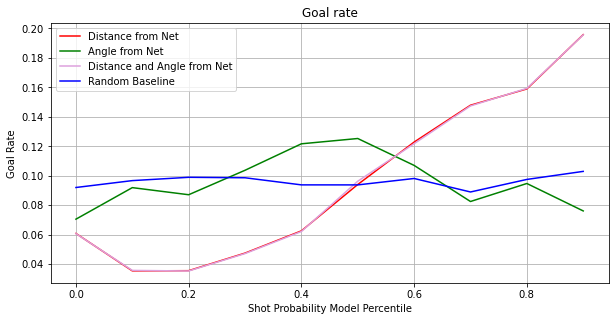

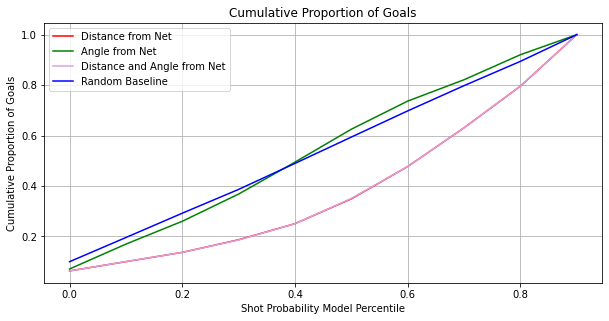

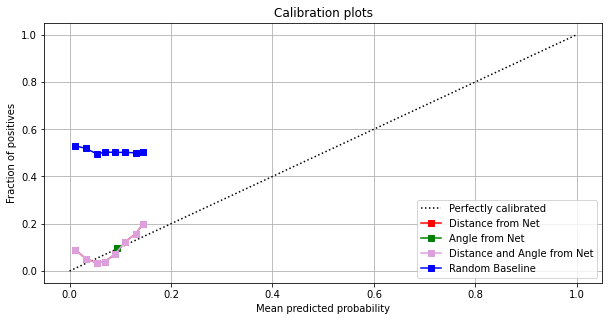

In [161]:
# ==========================================================================================
# Question 3.3:
# https://piazza.com/class/krgt4sfrgfp278?cid=261
# ==========================================================================================
def logistic_reg(X, y):

    # feature_color_dict = {
    #     1: [['Distance from Net'], 'r'],
    #     2: [['Angle from Net'], 'g'],
    #     3: [['Distance from Net', 'Angle from Net'], 'plum'],
    #     4: ['Random baseline', 'b']
    #     }
    
    #--------------------------------------
    # ROC
    #--------------------------------------
    plot_roc(X, y, feature_color_dict)
    plt.show()
    
    #--------------------------------------
    # Goal rate
    #--------------------------------------  
    plot_goal_rate(X, y, feature_color_dict)
    plt.show()
    
    #--------------------------------------
    # Cumulative proportion of goals
    #--------------------------------------  
    plot_cumulative_rate(X, y, feature_color_dict)
    plt.show()
    
    #--------------------------------------
    # Calibration
    #-------------------------------------- 
    plot_calibration(X, y, feature_color_dict)
    plt.show()

    
logistic_reg(X, y)

In [108]:
goal_prob = np.random.uniform(0,1,10)
goal_prob

array([0.38609937, 0.46041526, 0.16761943, 0.18427002, 0.92338808,
       0.86909476, 0.88505479, 0.69545121, 0.40697542, 0.55018635])

In [109]:
no_goal_prob = np.array([(1-i) for i in goal_prob])
no_goal_prob

array([0.61390063, 0.53958474, 0.83238057, 0.81572998, 0.07661192,
       0.13090524, 0.11494521, 0.30454879, 0.59302458, 0.44981365])

In [116]:
random_probs = np.column_stack((goal_prob,no_goal_prob))
random_probs

array([[0.38609937, 0.61390063],
       [0.46041526, 0.53958474],
       [0.16761943, 0.83238057],
       [0.18427002, 0.81572998],
       [0.92338808, 0.07661192],
       [0.86909476, 0.13090524],
       [0.88505479, 0.11494521],
       [0.69545121, 0.30454879],
       [0.40697542, 0.59302458],
       [0.55018635, 0.44981365]])

In [176]:
goal_prob = np.random.uniform(0,1,X_test.shape[0])
goal_prob

array([0.9015724 , 0.68400757, 0.62485779, ..., 0.25900943, 0.53653008,
       0.26741253])

In [177]:
goal_prob[0]

0.9015724033510861

In [182]:
# Value is 1 if goal_prob is greater than 0.5, 0 otherwise.
random_y_test = np.zeros((goal_prob.shape[0],1))
random_y_test[:,][np.where(goal_prob>0.5)]=1

In [183]:
random_y_test

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]])

In [ ]:
# ==========================================================================================
# comet.ml set up
# ==========================================================================================

1. Install comet_ml: `pip install comet_ml`

2. Save comet API as an environment variable

- Open a terminal and ```vim ~/.zshrc```
- Add API key by 
    - Enter editing mode: `i`
    - Paste the API variable: `export COMET_API_KEY = *** `
    - Save and quit: click 'esc' and enter `:wq`
- Reference: 
    - https://medium.com/@himanshuagarwal1395/setting-up-environment-variables-in-macos-sierra-f5978369b255
    - https://vim.rtorr.com/

3. 'ctrl+c' quit jupyter lab, enter `source ~/.zshrc`

4. Repoen the terminal ad check if the environment variable is here: `echo $COMET_API_KEY`

In [3]:
from comet_ml import Experiment
import os

In [5]:
exp = Experiment(
    api_key = os.environ.get("COMET_API_KEY"),
    project_name = 'milestone_2',
    workspace='xiaoxin-zhou')

exp.log_model('distance', 'q3/distance.pickle')

# required in Jupyter environment
exp.end()
# exp.log_model('angle')
# exp.log_model('distance_angle')

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/xiaoxin-zhou/milestone-2/1cfdca45897a4abfb759e743333770ff
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (3.11 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/xiaoxin-zhou/milestone-2/835c4fbb237f46caa90ba44f05c971c2

COMET ERROR: Ex